### 0. 패키지 로딩하기

In [8]:
from tqdm import tqdm
from tensorflow import keras
from PIL import Image, ImageDraw

import os
import cv2
import copy
import urllib3
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

urllib3.disable_warnings()

### 1. 모델을 훈련시킬 데이터 불러오기

In [2]:
# 처음 실행시 다운로드에 매우 긴 시간이 소요된다. 
(ds_train, ds_test), ds_info = tfds.load(
    "kitti",
    split         = ["train", "test"],
    shuffle_files = True,
    with_info     = True,
)

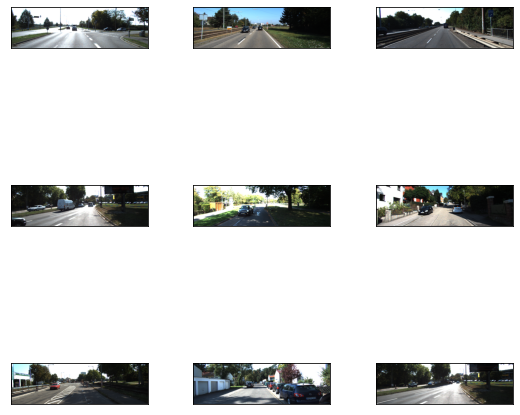

In [3]:
# 데이터 일부 확인하기
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
# 데이터 정보 확인하기
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel-dj52/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
    

### 3. 데이터를 하나 가져와서 확인해보기

In [5]:
TakeDataset = ds_train.take(1)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(6,), dtype=float32, numpy=array([-1.56,  2.14,  2.21,  2.11,  2.01,  1.96], dtype=float32)>, 'bbox': <tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[0.42517334, 0.41251206, 0.64573336, 0.46766505],
       [0.37224   , 0.        , 0.46832   , 0.04752013],
       [0.39485332, 0.05043478, 0.48541334, 0.1205314 ],
       [0.41941333, 0.11171497, 0.48904   , 0.16022544],
       [0.43210667, 0.14341384, 0.49584   , 0.18658616],
       [0.43274668, 0.17788245, 0.49442667, 0.21210144]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[ 3.52,  2.89, 10.81],
       [ 1.43,  1.48,  3.33],
       [ 1.62,  1.6 ,  4.18],
       [ 1.48,  1.35,  3.93],
       [ 1.5 ,  1.62,  4.08],
       [ 1.65,  1.57,  3.82]], dtype=float32)>, 'location': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[ -3.15,   1.87,  36.33],
       [-26.34,   2.66,  31.9

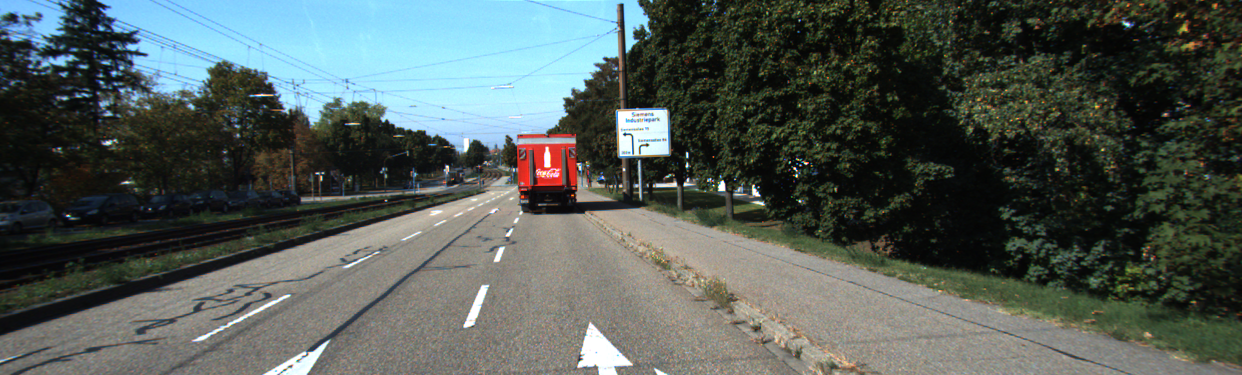

In [6]:
for example in TakeDataset:  
    print("------Example------")
    print(list(example.keys())) # example is "{"image" : tf.Tensor, "label" : tf.Tensor}"
    image    = example["image"]
    filename = example["image/file_name"].numpy().decode("utf-8")
    objects  = example["objects"]

print("------objects------")
print(objects)

img = Image.fromarray(image.numpy())
img

width : 1242 height : 375
(6, 4)
[512.33997 215.56    580.83997 132.84999]
[  0.       235.41      59.019997 199.37999 ]
[ 62.64    226.93001 149.7     192.97   ]
[138.75    217.72    198.99998 191.61   ]
[178.12    212.95999 231.74    189.06   ]
[220.93 212.72 263.43 189.59]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F0D13477210>


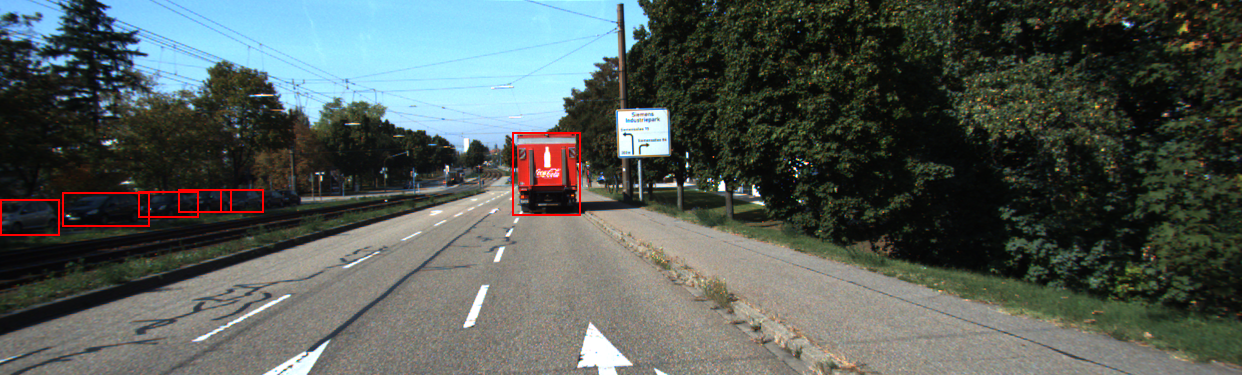

In [7]:
# 위에 보이는 이미지에 바운딩박스 그리기
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw        = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print("width :", width, "height :", height)
    print(object_bbox.shape)
    x_min = object_bbox[:, 1] * width
    x_max = object_bbox[:, 3] * width
    y_min = height - object_bbox[:, 0] * height
    y_max = height - object_bbox[:, 2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis = 1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline = (255, 0, 0), width = 2)
    print(input_image)
    
    return input_image

visualize_bbox(img, objects["bbox"].numpy())

### 4.  keras-retinanet 실습 (1) 데이터 포맷 변경

#### 4_1. 클래스 및 바운딩 박스 정보 추출

* 우리는 tensorflow_dataset의 API를 사용해 이미지와 각 이미지에 해당하는 바운딩 박스 라벨의 정보를 얻을 수 있다.
* 그렇다면 API를 활용하여 데이터를 추출, 이를 포맷팅 하여 CSV 형태로 한 줄씩 저장해 보자.
* 한 라인에 이미지 파일의 위치, 바운딩 박스 위치, 그리고 클래스 정보를 가지는 CSV 파일을 작성하도록 코드를 작성하고, 이를 사용해 CSV 파일을 생성한다.
* 우리가 생각하는 브레이크 시스템은 차와 사람을 구분해야 하는 점을 유의해야 한다.

In [9]:
data_dir       = os.getenv("HOME") + "/aiffel/object_detection/data"
img_dir        = os.getenv("HOME") + "/kitti_images"
train_csv_path = data_dir + "/kitti_train.csv"

# KITTI 데이터셋 ds_train을 파싱해서 dataframe으로 변환하는 parse_dataset 함수를 구현하기.
def parse_dataset(dataset, img_dir = "kitti_images", total = 0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    type_class_map = {
        0 : "car",
        1 : "car",
        2 : "car",
        3 : "person",
        4 : "person",
        5 : "person"
    }

    df = pd.DataFrame(columns = ["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total = total):
        filename = item["image/file_name"].numpy().decode("utf-8")
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item["image"].numpy())
        img.save(img_path)
        object_bbox   = item["objects"]["bbox"]
        object_type   = item["objects"]["type"].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis = 1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path"   : img_path,
                "x1"         : _rect[0],
                "y1"         : _rect[1],
                "x2"         : _rect[2],
                "y2"         : _rect[3],
                "class_name" : type_class_map[_type]
            }, ignore_index = True)
            break
    return df


df_train = parse_dataset(ds_train, img_dir, total = ds_info.splits["train"].num_examples)
df_train.to_csv(train_csv_path, sep = ",", index = False, header = False)

100%|██████████| 6347/6347 [13:53<00:00,  7.61it/s]


* 테스트 데이터셋에 대해서도 동일하게 parse_dataset() 을 적용해서 dataframe을 생성한다.

In [10]:
test_csv_path = data_dir + "/kitti_test.csv"

df_test = parse_dataset(ds_test, img_dir, total = ds_info.splits["test"].num_examples)
df_test.to_csv(test_csv_path, sep = ",", index = False, header = False)

100%|██████████| 711/711 [01:31<00:00,  7.74it/s]


#### 4_2. 클래스 맵핑

* 데이터셋에서 클래스는 문자열(string)으로 표시되지만, 모델에게 데이터를 알려줄 때에는 숫자를 사용해 클래스를 표시해야 한다. 
* 이때 모두 어떤 클래스가 있고 각 클래스가 어떤 인덱스(index)에 맵핑(mapping)될지 미리 정하고 저장해 두어야 학습을 한 후 추론(inference)을 할 때에도 숫자 인덱스로 나온 정보를 클래스 이름으로 바꾸어 해석할 수 있다.

In [11]:
class_txt_path = data_dir + "/classes.txt"

def save_class_format(path = "./classes.txt"):
    class_type_map = {
      "car"    : 0,
      "person" : 1
    }
    with open(path, mode = "w", encoding = "utf-8") as f:
        for k, v in class_type_map.items():
            f.write(f"{k}, {v}\n")
        


save_class_format(class_txt_path)

### 5. keras-retinanet 실습 (2) 셋팅

* 미리 설치해 둔 케라스 및 Keras RetinaNet 리포지토리를 사용한다.
* 학습이 잘 되기 위해서는 환경에 따라 batch_size나 worker, epoch를 조절해야 한다.
* 훈련 이미지 크기 또는 batch_size가 너무 크면 GPU에서 out-of-memory 에러가 날 수 있다.
* 원 개발자는 8GB 메모리도 RetinaNet을 훈련시키기에는 부족할 수 있다고 설명한다.

In [12]:
# RetinaNet 훈련이 시작!!
# 50epoch 훈련에 1시간 이상 소요될 수 있다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-13 16:30:37.269504: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-13 16:30:38.645676: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-13 16:30:38.667137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-13 16:30:38.667547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-13 16:30:38.667567: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-13 16:30:38.669692: I tensorflow/stream_executor/platform

Total params: 36,403,702
Trainable params: 36,297,462
Non-trainable params: 106,240
__________________________________________________________________________________________________
None
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
2021-04-13 16:30:48.398816: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-04-13 16:30:49.489525: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2021-04-13 16:30:49.523875: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-04-13 16:30:49.817710: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
195/195 [==============================] - E

195/195 [==============================] - ETA: 0s - loss: 1.1876 - regression_loss: 0.9202 - classification_loss: 0.2675
Epoch 00014: saving model to ./snapshots/resnet50_csv_14.h5
195/195 [==============================] - 56s 288ms/step - loss: 1.1876 - regression_loss: 0.9202 - classification_loss: 0.2675
Epoch 15/50
195/195 [==============================] - ETA: 0s - loss: 1.2181 - regression_loss: 0.9342 - classification_loss: 0.2839
Epoch 00015: saving model to ./snapshots/resnet50_csv_15.h5
195/195 [==============================] - 56s 288ms/step - loss: 1.2181 - regression_loss: 0.9342 - classification_loss: 0.2839
Epoch 16/50
195/195 [==============================] - ETA: 0s - loss: 1.2644 - regression_loss: 0.9821 - classification_loss: 0.2823
Epoch 00016: saving model to ./snapshots/resnet50_csv_16.h5

Epoch 00016: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
195/195 [==============================] - 56s 288ms/step - loss: 1.2644 - regression_loss:

195/195 [==============================] - ETA: 0s - loss: 1.2170 - regression_loss: 0.9328 - classification_loss: 0.2842
Epoch 00030: saving model to ./snapshots/resnet50_csv_30.h5
195/195 [==============================] - 56s 288ms/step - loss: 1.2170 - regression_loss: 0.9328 - classification_loss: 0.2842
Epoch 31/50
195/195 [==============================] - ETA: 0s - loss: 1.1209 - regression_loss: 0.8595 - classification_loss: 0.2614
Epoch 00031: saving model to ./snapshots/resnet50_csv_31.h5

Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.999999717180686e-11.
195/195 [==============================] - 56s 288ms/step - loss: 1.1209 - regression_loss: 0.8595 - classification_loss: 0.2614
Epoch 32/50
195/195 [==============================] - ETA: 0s - loss: 1.1445 - regression_loss: 0.8740 - classification_loss: 0.2704
Epoch 00032: saving model to ./snapshots/resnet50_csv_32.h5
195/195 [==============================] - 56s 288ms/step - loss: 1.1445 - regression_loss:

Epoch 46/50
195/195 [==============================] - ETA: 0s - loss: 1.1596 - regression_loss: 0.8921 - classification_loss: 0.2675
Epoch 00046: saving model to ./snapshots/resnet50_csv_46.h5
195/195 [==============================] - 57s 291ms/step - loss: 1.1596 - regression_loss: 0.8921 - classification_loss: 0.2675
Epoch 47/50
195/195 [==============================] - ETA: 0s - loss: 1.1611 - regression_loss: 0.8897 - classification_loss: 0.2714
Epoch 00047: saving model to ./snapshots/resnet50_csv_47.h5

Epoch 00047: ReduceLROnPlateau reducing learning rate to 9.999999010570977e-19.
195/195 [==============================] - 57s 290ms/step - loss: 1.1611 - regression_loss: 0.8897 - classification_loss: 0.2714
Epoch 48/50
195/195 [==============================] - ETA: 0s - loss: 1.1199 - regression_loss: 0.8664 - classification_loss: 0.2535
Epoch 00048: saving model to ./snapshots/resnet50_csv_48.h5
195/195 [==============================] - 57s 290ms/step - loss: 1.1199 - regr

* 아래 코드를 사용해 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환한다.

In [13]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-13 17:19:04.742019: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-13 17:19:06.322571: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-13 17:19:06.357074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-13 17:19:06.358555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-13 17:19:06.358631: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-13 17:19:06.361994: I tensorflow/stream_executor/platform

### 6. keras-retinanet 실습 (3) 시각화

* 위에서 변환한 모델을 load하고 추론 및 시각화를 해본다.
* 아래에 load된 모델을 통해 추론을 하고 시각화를 하는 함수를 작성한다. 일정 점수 이하는 경우를 제거해야 함을 유의해야 한다.

In [14]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = "0"
setup_gpu(gpu)

dir_path   = os.getenv("HOME") + "/aiffel/object_detection/"
model_path = os.path.join(dir_path, "snapshots", "resnet50_csv_50_infer.h5")
model      = load_model(model_path, backbone_name = "resnet50")

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[805.5751  144.14804 881.7543  175.95628]


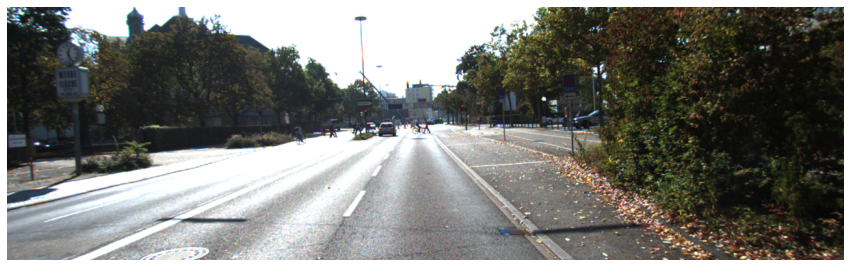

In [50]:
# inference_on_image 함수를 구현하기.
def inference_on_image(model, img_path = "./test_set/go_1.png", visualize = True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0 : (0, 0, 255), # blue
        1 : (255, 0, 0)  # red
    }

    # preprocess image for network
    image        = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis = 0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color = color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize = (15, 15))
        plt.axis("off")
        plt.imshow(draw)
        plt.show()            

        
img_path = os.getenv("HOME") + "/aiffel/object_detection/test_set/go_3.png"
inference_on_image(model, img_path = img_path)

[ 884.0576   181.31357 1237.374    373.6249 ]
[735.6694  163.25893 859.15924 245.83226]


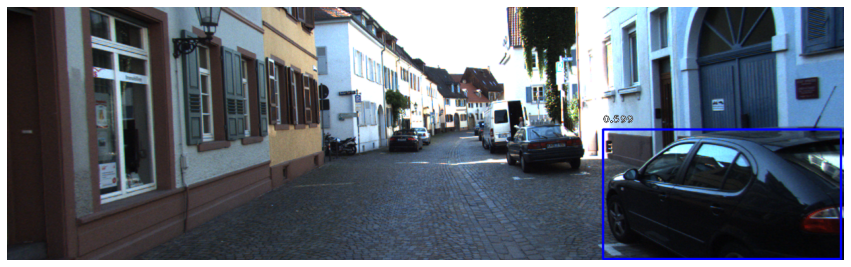

In [31]:
img_path = os.getenv("HOME") + "/aiffel/object_detection/test_set/stop_5.png"
inference_on_image(model, img_path = img_path)

### 7. 프로젝트 : 자율주행 보조 시스템 만들기

#### 7_1. 자율주행 시스템 만들기

* 위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만든다.
* 1. 입력으로 이미지 경로를 받는다.
* 2. 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환한다.
* 조건은 다음과 같다.
* 1. 사람이 한 명 이상 있는 경우
* 2. 차량의 크기(width or height)가 300px이상인 경우


In [49]:
def self_drive_assist(img_path, size_limit = 300):
    image = read_image_bgr(img_path)
    
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis = 0))
    boxes /= scale
    w = 0
    h = 0
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < 0.29:
            break
        
        b = box.astype(int)
        # 차량의 width, height
        w = b[2] - b[0]
        h = b[3] - b[1]
        
        # 차량의 크기가 limit size를 넘어가거나 사람이 한 명 이상 있는지 판단하여 다른 반환값 내기
        if w >= size_limit or h >= size_limit or label == 1:
            print(f"width : {w}, height : {h}, score : {score}, label : stop")
            return "Stop"
        
        else:
            print(f"width : {w}, height : {h}, score : {score}, label : go")
            return "Go"


img_path = os.getenv("HOME") + "/aiffel/object_detection/test_set/go_3.png"        
print(self_drive_assist(img_path))   

None


#### 7_2. 자율주행 시스템 평가하기

* 아래 test_system()를 통해서 위에서 만든 함수를 평가한다.
* 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해준다.

In [37]:
def test_system(func):
    work_dir = os.getenv("HOME") + "/aiffel/object_detection"
    score    = 0
    test_set = [
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png",   "Go"),
        ("test_set/go_2.png",   "Go"),
        ("test_set/go_3.png",   "Go"),
        ("test_set/go_4.png",   "Go"),
        ("test_set/go_5.png",   "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + "/" + image_file
        pred       = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

width : 69, height : 166, score : 0.6289830803871155, label : stop
width : 83, height : 167, score : 0.5933521389961243, label : stop
width : 312, height : 167, score : 0.6625086665153503, label : stop
width : 392, height : 289, score : 0.5435710549354553, label : stop
width : 353, height : 192, score : 0.5989477038383484, label : stop
width : 31, height : 30, score : 0.6986183524131775, label : go
width : 40, height : 35, score : 0.8151131272315979, label : go
width : 93, height : 77, score : 0.5839842557907104, label : go
width : 204, height : 120, score : 0.36905524134635925, label : go
90점입니다.


### 회고록

In [ ]:
# 가면 갈 수록 Deeper답게 자세하게 배우고, 코딩을 하는 듯 하다.
# 오늘은 오브젝트 디텍션이라 쉬울 줄 알았는데 마지막 프로젝트가 자율주행을 하기 위해 고, 스탑을 판단해야 해서 처음에 많이 당황했다.
# 생각도 안해본 분야이고, 어찌 접근해야 할지를 몰랐다.
# 그래서 처음에 위에서 짠 코드에서 boxes, scores, labels가 무엇을 반환하는지를 살펴봤다.
# 그리고 그림을 자세히 보니 박스 위에 숫자가 써있는 것을 보고 힌트를 얻었던 것 같다.
# 그리고 코드를 짜는데 90점이 나와서 무엇이 문제일지 봤는데, go_3의 반환값이 없어서 1개가 틀린 듯 하다.